In [ ]:
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.colors as mcolors

from matplotlib import pyplot as plt

import stats_mca_gemini as smg
import calendar
import math

In [3]:
path = "../../data0/yvu/ERA5/"
file = "era5_singlelvl_monthly_temperature.nc"

ds = xr.open_dataset(path+file)
ds = ds.rename({"valid_time":"time"})

# Keep latitude weights for later
weights = np.cos(np.deg2rad(ds.latitude))
weights.name = "weights"

ds['t2m'] = ds.t2m * ds.lsm # apply land-sea mask

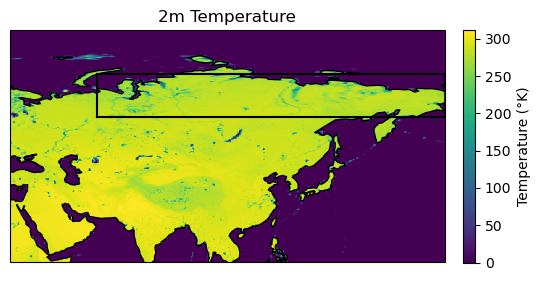

In [4]:
# Plot the 2m temperature in June 2020
fig, ax = plt.subplots(figsize=(6, 7), subplot_kw={'projection': ccrs.PlateCarree()})
ds.t2m.isel(time=5).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Temperature (°K)',
                                                                                                     'pad':0.04, 'fraction': 0.025})
ax.set_title('2m Temperature',fontsize=12)
ax.coastlines()
ax.set_xlim(30,180)
ax.set_ylim(10,90)


# Define the box coordinates for 60N-75N and 60E-180E
box_north, box_south, box_west, box_east = 75, 60, 60, 180

# Draw a black box around the specified region
ax.plot([box_west, box_east], [box_north, box_north], color='black', transform=ccrs.PlateCarree())
ax.plot([box_west, box_east], [box_south, box_south], color='black', transform=ccrs.PlateCarree())
ax.plot([box_west, box_west], [box_south, box_north], color='black', transform=ccrs.PlateCarree())
ax.plot([box_east, box_east], [box_south, box_north], color='black', transform=ccrs.PlateCarree())

# siberia line graphs and average anomaly calculations

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


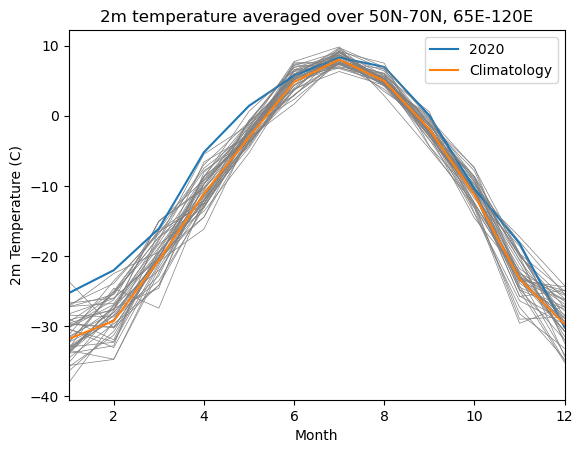

In [5]:
region=smg.siberia
month_start=1
month_end=12
min_lat = 50
max_lat = 70
min_lon = 65
max_lon = 120
var='t2m'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.weighted(weights).mean(dim=('longitude', 'latitude'))
clim = clim.groupby('time.month').mean(dim='time')

# plot single years in thin grey line
for i, year in enumerate(np.arange(1980,2024)):
    ds_year = ds_regional.isel(time=(ds.time.dt.year == year))
    ds_year = ds_year.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
    ds_year = ds_year.weighted(weights).mean(dim=('longitude', 'latitude'))
    if year == 2020:
        plt.plot(clim.month, ds_year-273.15,label="2020")
    else:
        plt.plot(clim.month, ds_year-273.15,linewidth=0.5, color='grey')

plt.plot(clim.month, clim-273.15, label="Climatology")
plt.xlim(1,12)
plt.xlabel("Month")
plt.ylabel("2m Temperature (C)")
plt.title("2m temperature averaged over 50N-70N, 65E-120E")
plt.legend()

Text(0.5, 1.0, 'Yearly Averaged Eurasian 2m Temperature')

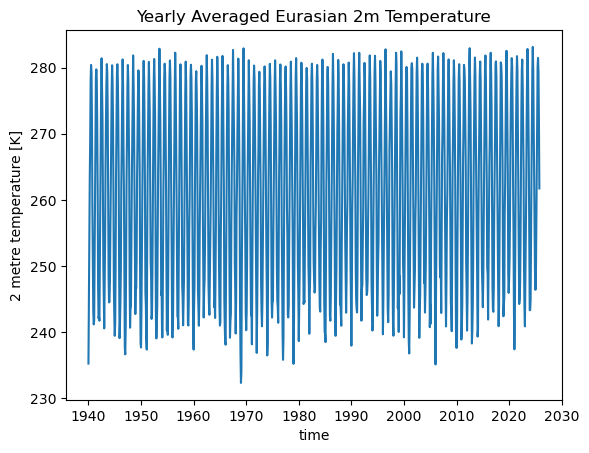

In [6]:
# Siberia
min_lat = 50
max_lat = 70
min_lon = 65
max_lon = 120

region = ds.t2m.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
region = region.weighted(weights).mean(dim=('longitude', 'latitude'))
region_yearly = (region-273.15).resample(time="YS").mean()
region.plot()
plt.title("Yearly Averaged Eurasian 2m Temperature")

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 5.


Text(0.5, 1.0, 'Siberia (50-70N, 65-120E) Average Jan-May 2m Temperature Anomaly')

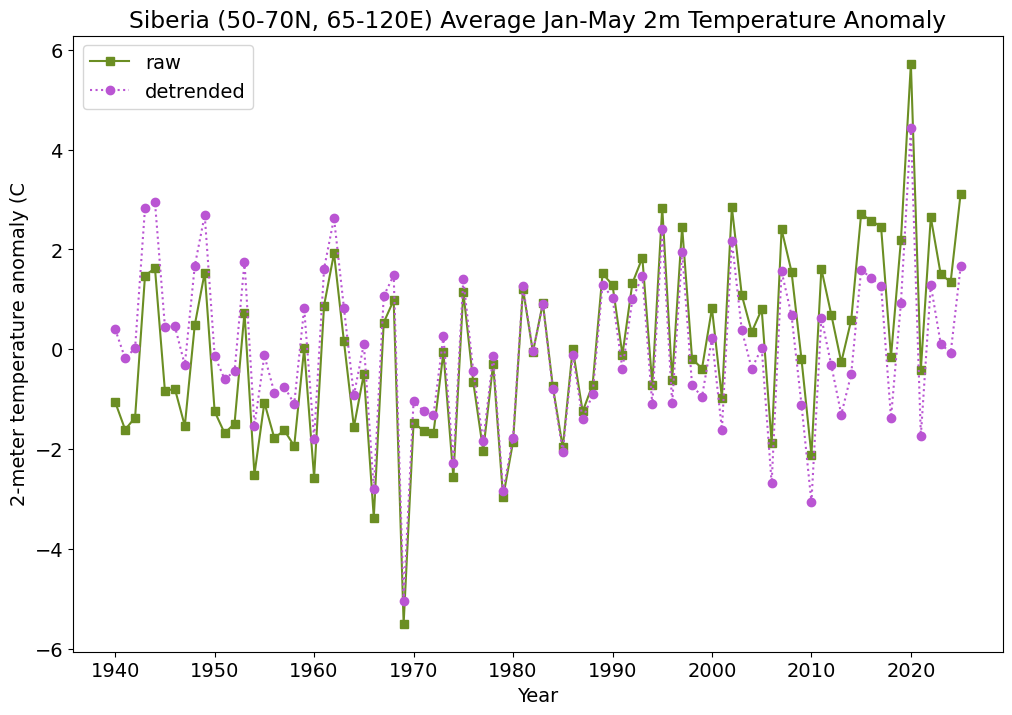

In [7]:
region=smg.siberia
month_start=1
month_end=5
var='t2m'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Detrend the resulting time series
anom_detrend = smg.detrend_dataarray(anom)

# 6. Take yearly average
anom=anom.resample(time='YS').mean()
anom_detrend=anom_detrend.resample(time='YS').mean()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 14})
anom.plot.line('-s',color='olivedrab',label="raw")
anom_detrend.plot.line(':o',color='mediumorchid',label="detrended")
plt.xlabel("Year")
plt.ylabel("2-meter temperature anomaly (C")
plt.legend()
plt.title("Siberia (50-70N, 65-120E) Average Jan-May 2m Temperature Anomaly")

# standardized anomaly, 2m temperature

In [8]:
# validate std function
# slice time/area of interest
siberia_clim = ds.t2m.isel(time=ds.time.dt.year.isin(np.arange(1980,2019+1)))

# method 1 of calulating std
std=siberia_clim.weighted(weights).mean(dim=('longitude', 'latitude'))
std=std.groupby('time.month').map(standardize)
print(std.mean())

### method 2 of calculating std
std2=siberia_clim.weighted(weights).mean(dim=('longitude', 'latitude'))
std2=(std2.groupby('time.month')-std2.groupby('time.month').mean()).groupby('time.month').std('time') # remove mean before calculating std

print(std2.mean().values)

<xarray.DataArray 't2m' ()> Size: 8B
array(0.6208235)
Coordinates:
    number   int64 8B 0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0
0.6208234988989622


Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
The detrended 2m temperature in Siberia during 2020 was 1.01 times the standard the deviation


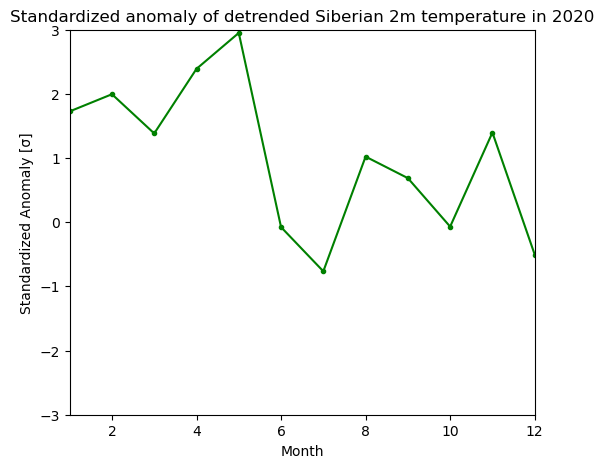

In [9]:
# DETRENDED VERSION (all steps)
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='t2m'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Detrend the resulting time series
anom_detrend = smg.detrend_dataarray(anom)

# 6. Standardize the detrended anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom_detrend.groupby('time.month').std(dim='time')
anom_detrend_standardized = anom_detrend.groupby('time.month') / monthly_std

print("The detrended 2m temperature in Siberia during 2020 was "+str(np.round(anom_detrend_standardized.sel(time="2020").mean().values,2))+" times the standard the deviation")

std_anom_detrend_2020=anom_detrend_standardized.sel(time="2020")
plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.plot(std_anom_detrend_2020.month,std_anom_detrend_2020,'g.-')
plt.xlabel("Month")
plt.xlim(1,12)
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-3,3)
plt.title("Standardized anomaly of detrended Siberian 2m temperature in 2020")
plt.show()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.
The detrended 2m temperature in Siberia during 2020 was 1.55 times the standard the deviation


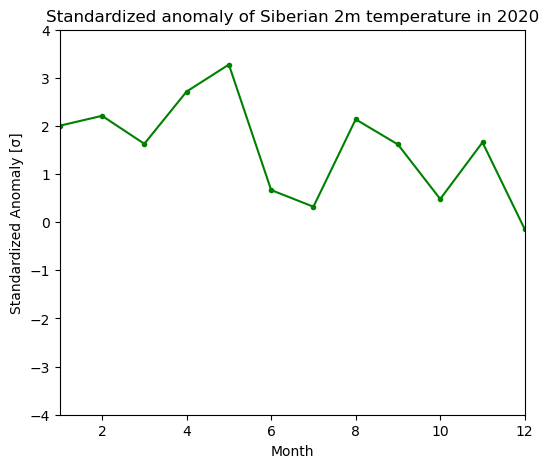

In [10]:
# With Linear trend (all Steps)
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='t2m'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Standardize the anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom.groupby('time.month').std(dim='time')
anom_standardized = anom.groupby('time.month') / monthly_std

print("The detrended 2m temperature in Siberia during 2020 was "+str(np.round(anom_standardized.sel(time="2020").mean().values,2))+" times the standard the deviation")
std_anom_2020=anom_standardized.sel(time="2020")
plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.plot(std_anom_2020.month,std_anom_2020,'g.-')
plt.xlabel("Month")
plt.xlim(1,12)
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-4,4)
plt.title("Standardized anomaly of Siberian 2m temperature in 2020")
plt.show()

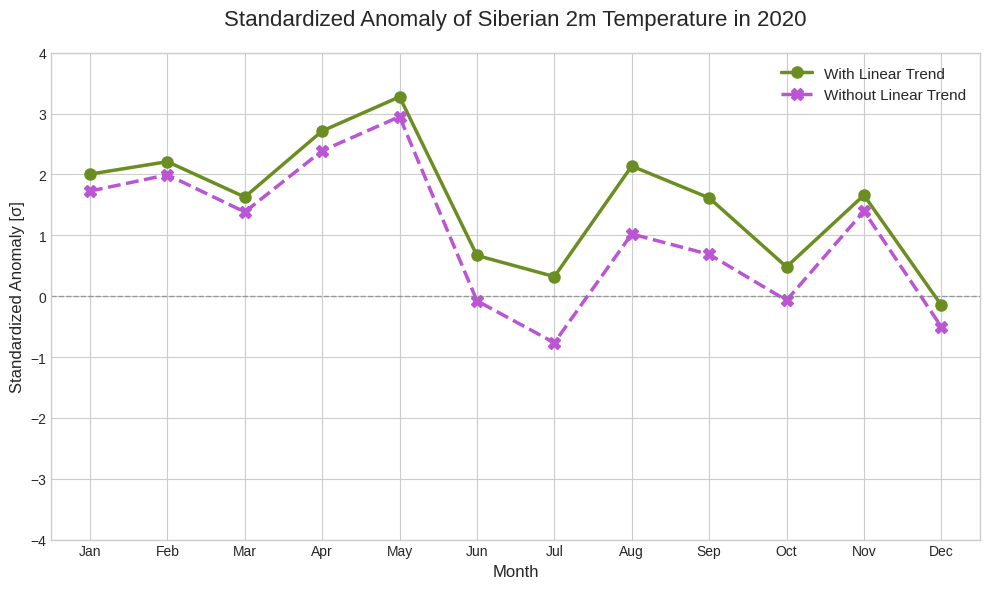

In [11]:
# --- Create Figure and Apply Style ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6)) # Control figure size for better proportions

# --- Plot Data with Enhanced Styling ---
# Plotting the first line (With Trend)
ax.plot(
    std_anom_2020.month, std_anom_2020,
    color='olivedrab',
    marker='o',
    linestyle='-',
    linewidth=2.5, # Slightly thicker line
    markersize=8,  # Larger markers
    label="With Linear Trend"
)

# Plotting the second line (Without Trend)
ax.plot(
    std_anom_detrend_2020.month, std_anom_detrend_2020,
    color='mediumorchid',
    marker='X',
    linestyle='--',
    linewidth=2.5,
    markersize=8,
    label="Without Linear Trend"
)

# --- Formatting and Labels ---
# Add a horizontal line at y=0 for reference
ax.axhline(0, color='grey', linestyle='--', linewidth=1, alpha=0.7)

# Set titles and labels with improved fontsizes
ax.set_title("Standardized Anomaly of Siberian 2m Temperature in 2020", fontsize=16, pad=20)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Standardized Anomaly [σ]", fontsize=12)

# Set axis limits
ax.set_xlim(0.5, 12.5) # Add a little padding to the x-axis
ax.set_ylim(-4, 4)

# Set custom x-axis ticks to show month names
month_labels = [calendar.month_abbr[i] for i in range(1, 13)]
ax.set_xticks(ticks=range(1, 13))
ax.set_xticklabels(month_labels)

# Place legend in the best location automatically
ax.legend(fontsize=11, loc='best')

# Ensure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


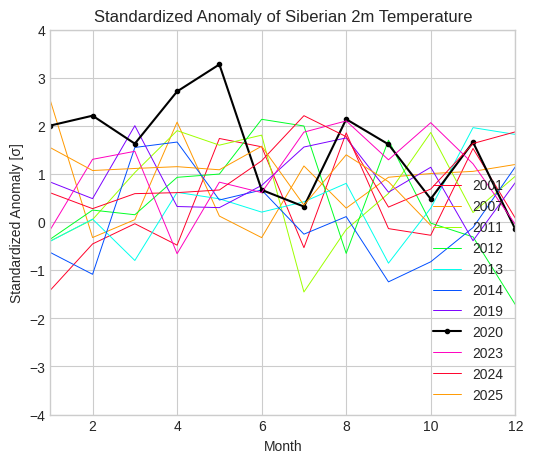

In [12]:
# With Linear Trend
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='t2m'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Standardize the anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom.groupby('time.month').std(dim='time')
anom_standardized = anom.groupby('time.month') / monthly_std

base_cmap = plt.get_cmap("gist_rainbow")
color_list = base_cmap(np.linspace(0, 1, 8))
cmap = mcolors.ListedColormap(color_list)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_list)

# Create a boolean DataArray: True if standardized anomaly > 2 sigma
above_threshold = (anom_standardized > 1.5)

# Use rolling sum on the boolean converted to int (True=1, False=0) for summing
cumulative_sum = above_threshold.cumsum()
reset_points = cumulative_sum.where(~above_threshold).ffill(dim='time').fillna(0)
consecutive_counts = cumulative_sum - reset_points # months that aren't above 2 sigma bring the count back down to 0
# Index dates where the counts are above two
consecutive_counts = consecutive_counts.where(consecutive_counts>=2).dropna(dim='time')
consecutive_counts = np.unique(consecutive_counts['time'].dt.year)
# Return as a standard python list
# print('The years with at least two consecutive months above two sigma are: ',sorted(list(consecutive_counts)))
for i, year in enumerate(consecutive_counts):
    ds_year = anom_standardized.sel(time=str(year))
    if year == 2020:
        plt.plot(ds_year.time.dt.month, ds_year,'k.-',label='2020')
    else:
        plt.plot(ds_year.time.dt.month, ds_year,linewidth=0.7,label=str(ds_year.time.dt.year[0].values))#, color=colors[i])

plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.xlabel("Month")
plt.xlim(1,12)
plt.legend(loc='lower right')
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-4,4)
plt.title("Standardized Anomaly of Siberian 2m Temperature")
plt.savefig('2020siberianheatwave-stdanom-allyears.png')
plt.show()

Slicing data for the 'Siberia' region.
Filtering for months: 1 through 12.


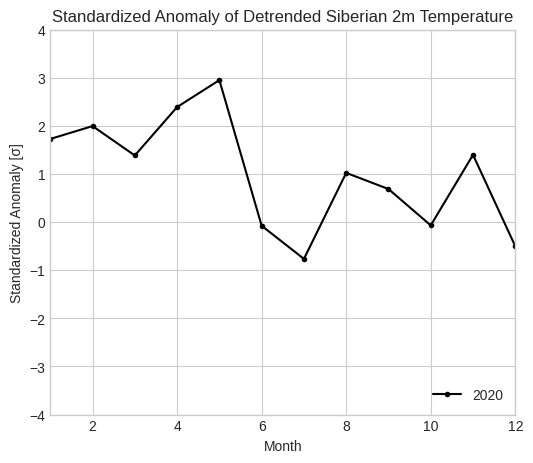

In [13]:
# Detrended
# calculate where 2020 lies in the standard deviation
region=smg.siberia
month_start=1
month_end=12
var='t2m'

ds_regional = smg.select_region_and_time(ds, month_start, month_end, region=region)

# 2. Apply latitude weighting for accurate spatial averaging
weights = np.cos(np.deg2rad(ds_regional.latitude))
weights.name = "weights"

# 3. Select the variable and calculate anomalies based on the climatology for 1951-1980
ds_regional = ds_regional[var]
clim = ds_regional.groupby('time.month').mean(dim='time')
anom = ds_regional.groupby('time.month') - clim

# 4. Spatially average the anomalies to get a single time series
anom = anom.weighted(weights).mean(dim=('longitude', 'latitude'))

# 5. Detrend the resulting time series
anom_detrend = smg.detrend_dataarray(anom)

# 6. Standardize the detrended anomalies
# The anomaly is standardized by the standard deviation of that month's anomalies
monthly_std = anom_detrend.groupby('time.month').std(dim='time')
anom_detrend_standardized = anom_detrend.groupby('time.month') / monthly_std

base_cmap = plt.get_cmap("gist_rainbow")
color_list = base_cmap(np.linspace(0, 1, 8))
cmap = mcolors.ListedColormap(color_list)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_list)

# Create a boolean DataArray: True if standardized anomaly > 2 sigma
above_threshold = (anom_detrend_standardized > 2)

# Use rolling sum on the boolean converted to int (True=1, False=0) for summing
cumulative_sum = above_threshold.cumsum()
reset_points = cumulative_sum.where(~above_threshold).ffill(dim='time').fillna(0)
consecutive_counts = cumulative_sum - reset_points # months that aren't above 2 sigma bring the count back down to 0
# Index dates where the counts are above two
consecutive_counts = consecutive_counts.where(consecutive_counts>=2).dropna(dim='time')
consecutive_counts = np.unique(consecutive_counts['time'].dt.year)
# Return as a standard python list
# print('The years with at least two consecutive months above two sigma are: ',sorted(list(consecutive_counts)))
for i, year in enumerate(consecutive_counts):
    ds_year = anom_detrend_standardized.sel(time=str(year))
    if year == 2020:
        plt.plot(ds_year.time.dt.month, ds_year,'k.-',label='2020')
    else:
        plt.plot(ds_year.time.dt.month, ds_year,linewidth=0.7,label=str(ds_year.time.dt.year[0].values))#, color=colors[i])

plt.rcParams.update({'figure.figsize': (6,5),
                    'font.size': 10})
plt.xlabel("Month")
plt.xlim(1,12)
plt.legend(loc='lower right')
plt.ylabel("Standardized Anomaly [σ]")
plt.ylim(-4,4)
plt.title("Standardized Anomaly of Detrended Siberian 2m Temperature")
plt.savefig('2020siberianheatwave-detrend-stdanom-allyears.png')
plt.show()

# plot 2m temperature for 1991 2020

In [ ]:
# choose date range for climatology calculation
month_start = 1
year_start = 1980

month_end = 12
year_end = 2018

ds_sub = ds.t2m.isel(time=ds.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.year.isin(np.arange(year_start,year_end+1)))

ds_heat = ds.t2m.isel(time=ds.time.dt.year.isin([2019,2020]))

clim=ds_sub.groupby('time.month').mean(dim='time') # generate monthly climatology
anom=ds_heat.groupby('time.month') - clim # generate 2020 monthly anomaly
anom

In [ ]:
anom_sub = anom.isel(time=np.arange(10,19))
anom_sub

In [ ]:
## plot 2020 2m temperature anomalies
months = ['December','January', 'February', 'March', 
          'April', 'May', 'June','July']

# Define the box coordinates for 60N-75N and 60E-180E
box_north, box_south, box_west, box_east = 80, 40, 0, 180

fig, ax = plt.subplots(2, 4, figsize=(10,5), layout='constrained',subplot_kw={'projection': ccrs.PlateCarree()}) # subplot_kw={'projection': ccrs.Robinson()}
ax = ax.flatten()

for i, month in enumerate(months):
    # cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'label':'2 Metre Temperature Anomaly [K]'}
    # #  "pad" : .05, 'aspect':40,
    # ds_2020_anom["t2m"][i].plot(ax=ax[i], transform=ccrs.Robinson(), cbar_kwargs=cbar_kwargs, 
    #                             levels=np.arange(-15,16), robust=True)
    # ax[i].coastlines()
    # plt.title(month)
    
    ax1 = ax[i].contourf(anom_sub.longitude,anom_sub.latitude,anom_sub.isel(time=i),cmap="RdBu_r",
                         levels=np.arange(-10,10),extend='both',transform=ccrs.PlateCarree())
    ax[i].coastlines() 
    # Draw a black box around the specified region
    ax[i].plot([box_west, box_east], [box_north, box_north], color='black', transform=ccrs.PlateCarree())
    ax[i].plot([box_west, box_east], [box_south, box_south], color='black', transform=ccrs.PlateCarree())
    ax[i].plot([box_west, box_west], [box_south, box_north], color='black', transform=ccrs.PlateCarree())
    ax[i].plot([box_east, box_east], [box_south, box_north], color='black', transform=ccrs.PlateCarree())
    if np.isin(i,np.arange(0,1))==True:
        ax[i].set_title(month+" 2019")
    else:
        ax[i].set_title(month+" 2020")
fig.colorbar(ax1,ax=ax,orientation='horizontal', shrink=0.5, pad=0.1, location='bottom',extend='both',
            label='2m temperature anomaly')
# plt.tight_layout()
plt.show()

In [ ]:
anom_sub.isel(time=2)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()}) # subplot_kw={'projection': ccrs.Robinson()}
ax.contourf(anom_sub.longitude,anom_sub.latitude,anom_sub.isel(time=2),
                                    cmap="RdBu_r",levels=np.arange(-10,10), extend='both')#, transform=ccrs.PlateCarree())

In [ ]:
## same as above but for 1995
# choose date range for climatology calculation
month_start = 1
year_start = 1980

month_end = 12
year_end = 2018

ds_sub = ds.t2m.isel(time=ds.time.dt.month.isin(np.arange(month_start,month_end+1)))
ds_sub = ds_sub.isel(time=ds_sub.time.dt.year.isin(np.arange(year_start,year_end+1)))

ds_heat = ds.t2m.isel(time=ds.time.dt.year.isin([1991]))

clim=ds_sub.groupby('time.month').mean(dim='time') # generate monthly climatology
anom=ds_heat.groupby('time.month') - clim # generate 2020 monthly anomaly
anom

In [ ]:
## plot 2020 2m temperature anomalies
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August','September','October','November', 'December',]

fig, ax = plt.subplots(4, 3, figsize=(12,8), layout='constrained',subplot_kw={'projection': ccrs.PlateCarree()}) # subplot_kw={'projection': ccrs.Robinson()}
ax = ax.flatten()

for i, month in enumerate(months):
    # cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'label':'2 Metre Temperature Anomaly [K]'}
    # #  "pad" : .05, 'aspect':40,
    # ds_2020_anom["t2m"][i].plot(ax=ax[i], transform=ccrs.Robinson(), cbar_kwargs=cbar_kwargs, 
    #                             levels=np.arange(-15,16), robust=True)
    # ax[i].coastlines()
    # plt.title(month)
    
    ax1 = ax[i].contourf(anom.longitude,anom.latitude,anom.isel(time=i),cmap="RdBu_r",
                         levels=np.arange(-10,10),extend='both',transform=ccrs.PlateCarree())
    ax[i].coastlines() 
    ax[i].set_title(month+" 1991")
fig.colorbar(ax1,ax=ax[7],orientation='horizontal', shrink=0.9, pad=0.1, location='bottom',extend='both')
# plt.tight_layout()
plt.show()

# plot SSTs for 1995 and 2020

In [ ]:
north_atlantic = {
    'min_lat': 0,
    'max_lat': 90,
    'min_lon': 275,
    'max_lon': 360,
}

# detrend data
ds_sub = ds.sel(latitude=slice(north_atlantic["max_lat"],north_atlantic["min_lat"]),longitude=slice(north_atlantic["min_lon"],north_atlantic["max_lon"]))
ds_sub = detrend(ds_sub,"sst")

# choose date range for climatology calculation
ds_anom2020 = ds_sub.isel(time=ds.time.dt.year.isin([2019,2020]))
ds_anom1995 = ds_sub.isel(time=ds.time.dt.year.isin([1994,1995]))

clim=ds_sub.groupby('time.month').mean(dim='time') # generate monthly climatology
anom2020=ds_anom2020.groupby('time.month') - clim # generate 2019-2020 monthly anomaly
anom1995=ds_anom1995.groupby('time.month') - clim # generate 1994-1995 monthly anomaly

In [ ]:
## plot 2020 sst anomalies
fig, ax = plt.subplots(3, 4, figsize=(10,8),layout='constrained',subplot_kw={'projection': ccrs.PlateCarree()}) # subplot_kw={'projection': ccrs.Robinson()}
ax = ax.flatten()
anom=anom2020.sel(time=slice("2019-09-01", "2020-08-02"))
for i, month in enumerate(anom.time):
    ax1 = ax[i].contourf(anom.longitude,anom.latitude,anom.isel(time=i),cmap="RdBu_r",
                         extend='both',transform=ccrs.PlateCarree(),levels=np.arange(-2,2.5,0.5))
    ax[i].coastlines() 
    ax[i].set_title(str(anom.isel(time=i).time.values.astype('datetime64[M]')))

fig.colorbar(ax1,ax=ax,orientation='horizontal', shrink=0.5, pad=0.01, location='bottom',extend='both',
            label='Detrended SST Anomaly [degC]')
# plt.tight_layout()
plt.show()

In [ ]:
## plot 1995 sst anomalies
fig, ax = plt.subplots(3, 4, figsize=(10,8),layout='constrained',subplot_kw={'projection': ccrs.PlateCarree()}) # subplot_kw={'projection': ccrs.Robinson()}
ax = ax.flatten()
anom=anom1995.sel(time=slice("1994-09-01", "1995-08-02"))
for i, month in enumerate(anom.time):
    ax1 = ax[i].contourf(anom.longitude,anom.latitude,anom.isel(time=i),cmap="RdBu_r",
                         extend='both',transform=ccrs.PlateCarree(),levels=np.arange(-2,2.5,0.5))
    ax[i].coastlines() 
    ax[i].set_title(str(anom.isel(time=i).time.values.astype('datetime64[M]')))

fig.colorbar(ax1,ax=ax,orientation='horizontal', shrink=0.5, pad=0.1, location='bottom',extend='both',
            label='SST Anomaly [degC]')
# plt.tight_layout()
plt.show()